In [3]:
# Step 1 (fixed): load config directly from its known location and connect to DuckDB
from pathlib import Path
import json, duckdb, pandas as pd

# Use the config file path directly (no PATHS variable needed here)
CONFIG_PATH = Path("kwh_prediction/config/config.json")

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    CFG = json.load(f)

DUCK_PATH = CFG["io"]["duckdb_path"]
TABLE     = CFG["io"]["table"]
DATE_COL  = CFG["data"]["date_col"]
ID_COL    = CFG["data"]["id_col"]
TARGET    = CFG["data"]["target_col"]
LOC_COL   = CFG["data"]["location_col"]
RES_COL   = CFG["data"]["residence_col"]
GHC_COL, PAY_COL = CFG["data"]["currency_cols"]
UNRELIABLE_AFTER = CFG["time"]["unreliable_after"]

# Connect and query
con = duckdb.connect(DUCK_PATH)

query = f"""
SELECT
  {DATE_COL}::DATE AS {DATE_COL},
  {ID_COL}::BIGINT AS {ID_COL},
  {TARGET}::DOUBLE AS {TARGET},
  {GHC_COL}::DOUBLE AS {GHC_COL},
  {PAY_COL}::DOUBLE AS {PAY_COL},
  {LOC_COL}::VARCHAR AS {LOC_COL},
  {RES_COL}::VARCHAR AS {RES_COL}
FROM {TABLE}
WHERE {DATE_COL} <= DATE '{UNRELIABLE_AFTER}'
"""
df = con.execute(query).fetchdf()

print("Rows:", len(df), "| Columns:", list(df.columns))
print("Date range:", df[DATE_COL].min(), "→", df[DATE_COL].max())
print("Unique meters:", df[ID_COL].nunique())
display(df.head(10))

con.close()


Rows: 2789678 | Columns: ['chargedate', 'meterid', 'kwh', 'ghc', 'paymoney', 'loc', 'res']
Date range: 2012-07-17 00:00:00 → 2020-09-30 00:00:00
Unique meters: 69027


,chargedate,meterid,kwh,ghc,paymoney,loc,res
0,2019-02-15,1,14.2,23.1705,140.0,Techiman [13],N-Resid [0]
1,2019-03-11,1,57.4,38.8886,40.0,Techiman [13],N-Resid [0]
2,2019-04-20,1,57.4,38.8886,20.0,Techiman [13],N-Resid [0]
3,2019-05-28,1,57.4,38.8886,20.0,Techiman [13],N-Resid [0]
4,2019-06-25,1,57.4,38.8886,20.0,Techiman [13],N-Resid [0]
5,2019-07-09,1,50.1,37.7353,40.0,Techiman [13],N-Resid [0]
6,2019-08-10,1,28.4,21.3909,40.0,Techiman [13],N-Resid [0]
7,2019-09-03,1,28.4,21.3909,40.0,Techiman [13],N-Resid [0]
8,2019-10-01,1,46.5,37.1024,40.0,Techiman [13],N-Resid [0]
9,2019-11-04,1,36.2,28.8840,50.0,Techiman [13],N-Resid [0]


In [4]:
# Step 2: schema validation & sanity checks
import numpy as np

# 1. Check duplicates per meterid-date
dupes = df.duplicated(subset=["meterid", "chargedate"], keep=False)
dupe_count = dupes.sum()

print(f"Duplicate rows (same meterid + date): {dupe_count}")

if dupe_count > 0:
    display(df.loc[dupes].sort_values(["meterid", "chargedate"]).head(10))

# 2. Null counts per column
print("\nNull counts:")
display(df.isna().sum())

# 3. Numeric sanity
for col in ["kwh", "ghc", "paymoney"]:
    neg = (df[col] < 0).sum()
    zero = (df[col] == 0).sum()
    print(f"{col:10s}  negative: {neg:6d} | zero: {zero:6d}")

# 4. Quick descriptive stats
display(df.describe().T.round(3))


Duplicate rows (same meterid + date): 0

Null counts:


chargedate        0
meterid           0
kwh           59534
ghc               0
paymoney      39318
loc               0
res               0
dtype: int64

kwh         negative:      0 | zero:      0
ghc         negative:      0 | zero:      0
paymoney    negative:      0 | zero:   1471


,count,mean,min,25%,50%,75%,max,std
chargedate,2789678,2018-01-12 21:36:24.925715,2012-07-17 00:00:00,2016-09-26 00:00:00,2018-06-27 00:00:00,2019-08-23 00:00:00,2020-09-30 00:00:00,NaN
meterid,2789678.0,29985.231068,1.0,9811.0,30815.0,47337.0,69065.0,20893.492176
kwh,2730144.0,125.771797,1.3,50.0,87.0,150.21,3878.0,158.624223
ghc,2789678.0,84.461396,0.0353,16.3679,38.2911,73.0089,220925.0,465.394182
paymoney,2750360.0,48.157915,0.0,15.0,30.0,50.0,3000.0,95.002801


Loaded cleaned dataset: (2730144, 7)


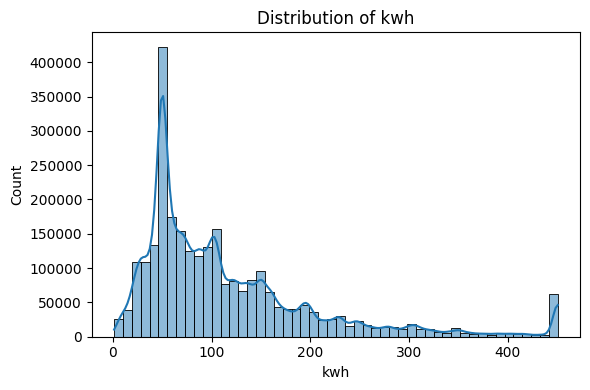

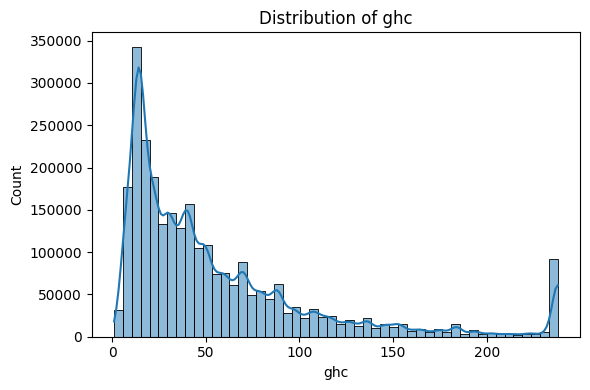

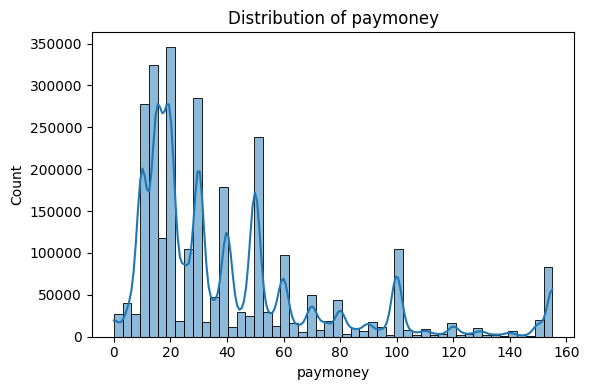


Top 10 locations:


loc
Techiman [13]    1422326
Wenchi [14]       454128
Atebubu [3]       135146
Akomadan [2]      124022
Yeji [15]         121929
Nkoranza [10]     114191
Kintampo [8]       93108
Kdanso [9]         61201
Nsawkaw [11]       59120
Ejura [6]          43203
Name: count, dtype: int64


Top 10 residence types:


res
Resid [1]      2186355
N-Resid [0]     543789
Name: count, dtype: int64

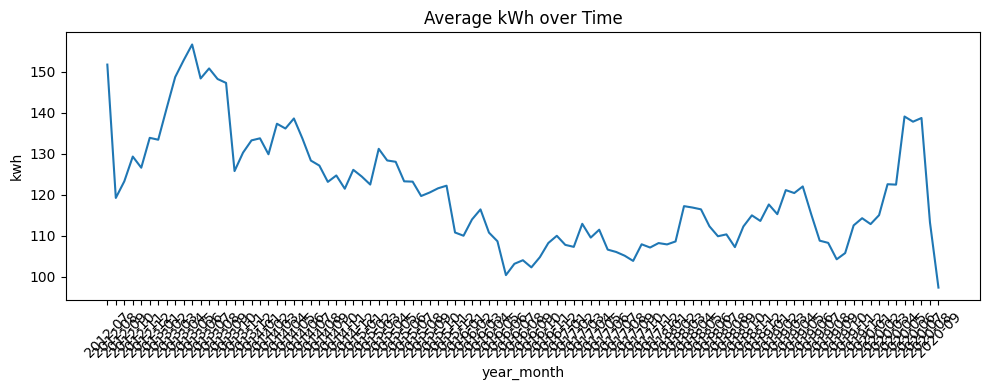

In [6]:
# Step 4 (fixed): reload cleaned data and run EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reload cleaned file
clean_path = "kwh_prediction/data/clean/energy_clean.parquet"
df = pd.read_parquet(clean_path)
print("Loaded cleaned dataset:", df.shape)

# 1️⃣ Numeric distributions
numeric_cols = ["kwh", "ghc", "paymoney"]
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# 2️⃣ Categorical summaries
print("\nTop 10 locations:")
display(df["loc"].value_counts().head(10))

print("\nTop 10 residence types:")
display(df["res"].value_counts().head(10))

# 3️⃣ Temporal trend
df["year_month"] = df["chargedate"].dt.to_period("M").astype(str)
trend = df.groupby("year_month")["kwh"].mean().reset_index()

plt.figure(figsize=(10,4))
sns.lineplot(data=trend, x="year_month", y="kwh")
plt.xticks(rotation=45)
plt.title("Average kWh over Time")
plt.tight_layout()
plt.show()


In [7]:
df['kwh'].describe(percentiles=[0.95, 0.99, 0.999])
df['kwh'].value_counts().sort_index().tail(10)

kwh
450.68        1
450.69        3
450.70        9
450.76        2
450.77        1
450.78        1
450.79        1
450.80        1
450.81        3
450.84    60575
Name: count, dtype: int64

In [8]:
df.loc[df["kwh"] >= 450.84, ["kwh", "ghc"]].describe()

# and see if all high values share the same ratio
df["tariff_est"] = df["ghc"] / df["kwh"]
print("Unique tariff rates at cap:", df.loc[df["kwh"] >= 450.84, "tariff_est"].nunique())
display(df.loc[df["kwh"] >= 450.84, "tariff_est"].value_counts().head())


Unique tariff rates at cap: 1050


tariff_est
0.527958    55769
0.434571      376
0.217884      246
0.195725      197
0.379373      177
Name: count, dtype: int64

In [10]:
# Convert Interval dtype -> string or codes, and save parquet safely
from pathlib import Path

# If you created tariff_group via qcut, convert it:
if "tariff_group" in df.columns and str(df["tariff_group"].dtype).startswith("category"):
    # option A: human-readable strings
    df["tariff_group"] = df["tariff_group"].astype(str)
    # option B (smaller): numeric codes
    # df["tariff_group"] = df["tariff_group"].cat.codes.astype("int16")

# Booleans are fine, but you can compress:
if "is_capped" in df.columns:
    df["is_capped"] = df["is_capped"].astype("bool")  # or .astype("uint8")

# Ensure no other unsupported dtypes slipped in
unsupported = [c for c in df.columns if df[c].dtype.name.startswith("Interval")]
print("Unsupported interval cols:", unsupported)

# Save (overwrite if exists)
clean_path = Path("kwh_prediction/data/clean/energy_clean.parquet")
if clean_path.exists():
    clean_path.unlink()  # remove old schema to avoid mismatch
df.to_parquet(clean_path, index=False)
print(f"✅ Saved: {clean_path}")


Unsupported interval cols: []
✅ Saved: kwh_prediction\data\clean\energy_clean.parquet


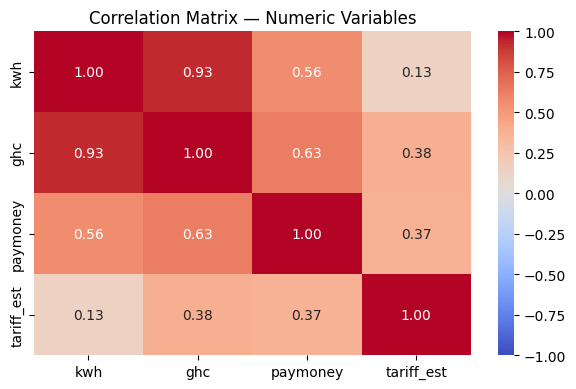

,kwh,ghc,paymoney,tariff_est
kwh,1.000000,0.929407,0.556606,0.134609
ghc,0.929407,1.000000,0.632072,0.384377
paymoney,0.556606,0.632072,1.000000,0.372490
tariff_est,0.134609,0.384377,0.372490,1.000000


In [12]:
# Step 5: correlation matrix for numeric features
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ["kwh", "ghc", "paymoney"]
if "tariff_est" in df.columns:
    numeric_cols.append("tariff_est")

corr = df[numeric_cols].corr(method="pearson")

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix — Numeric Variables")
plt.tight_layout()
plt.show()

corr


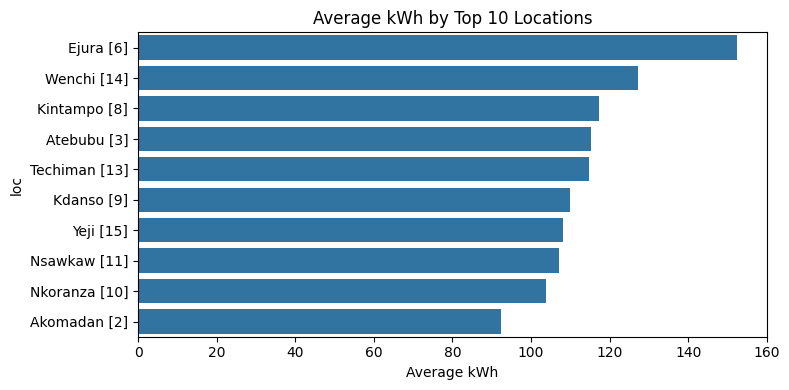

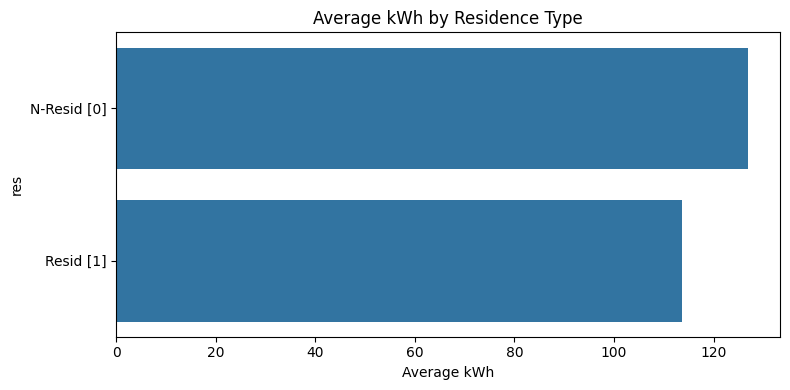

C:\Users\Asus\AppData\Local\Temp\ipykernel_13192\3522148897.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_usage = df.groupby("season")["kwh"].mean()


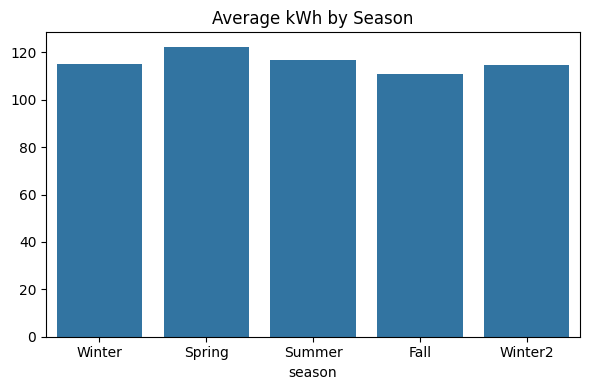

In [13]:
# Step 6: Explore categorical and temporal relationships
import matplotlib.pyplot as plt
import seaborn as sns

# Average kWh by location
top_locs = df["loc"].value_counts().head(10).index
loc_usage = df[df["loc"].isin(top_locs)].groupby("loc")["kwh"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=loc_usage.values, y=loc_usage.index)
plt.title("Average kWh by Top 10 Locations")
plt.xlabel("Average kWh")
plt.tight_layout()
plt.show()

# Average kWh by residence type
top_res = df["res"].value_counts().head(10).index
res_usage = df[df["res"].isin(top_res)].groupby("res")["kwh"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=res_usage.values, y=res_usage.index)
plt.title("Average kWh by Residence Type")
plt.xlabel("Average kWh")
plt.tight_layout()
plt.show()

# Seasonal average (based on chargedate)
df["month_num"] = df["chargedate"].dt.month
df["season"] = pd.cut(df["month_num"], bins=[0,2,5,8,11,12],
                      labels=["Winter","Spring","Summer","Fall","Winter2"],
                      include_lowest=True)
season_usage = df.groupby("season")["kwh"].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=season_usage.index, y=season_usage.values)
plt.title("Average kWh by Season")
plt.tight_layout()
plt.show()


count    2.730144e+06
mean     9.520784e-01
std      4.744841e-01
min      0.000000e+00
25%      5.485253e-01
50%      1.120941e+00
75%      1.245896e+00
max      2.000000e+00
Name: pay_ratio, dtype: float64


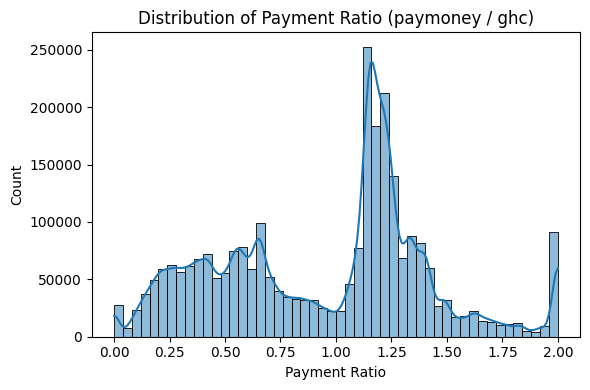

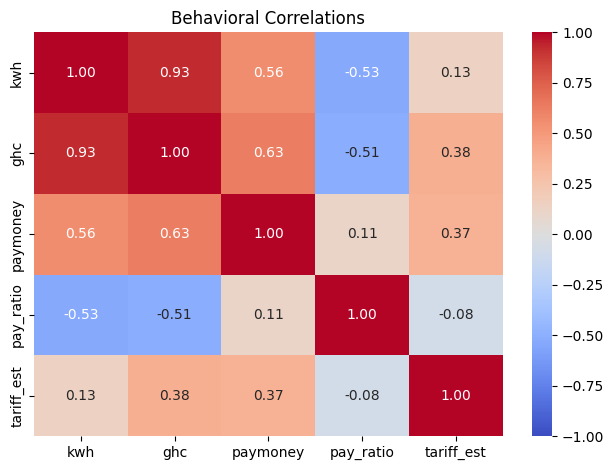

In [14]:
# Step 7: Payment behavior analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Create payment ratio
df["pay_ratio"] = (df["paymoney"] / df["ghc"]).clip(0, 2)  # cap extreme overpayments

# Summary
print(df["pay_ratio"].describe())

# Distribution plot
plt.figure(figsize=(6,4))
sns.histplot(df["pay_ratio"], bins=50, kde=True)
plt.title("Distribution of Payment Ratio (paymoney / ghc)")
plt.xlabel("Payment Ratio")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Correlation with kWh and tariff
corr_behavior = df[["kwh", "ghc", "paymoney", "pay_ratio", "tariff_est"]].corr()
sns.heatmap(corr_behavior, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Behavioral Correlations")
plt.tight_layout()
plt.show()



In [15]:
# Drop billing/payment variables entirely
df = df.drop(columns=["ghc", "paymoney"], errors="ignore")
print("Remaining columns:", df.columns.tolist())


Remaining columns: ['chargedate', 'meterid', 'kwh', 'loc', 'res', 'year_month', 'tariff_est', 'is_capped', 'tariff_group', 'month_num', 'season', 'pay_ratio']


In [16]:
df = df.drop(columns=["pay_ratio", "tariff_est", "is_capped_ghc"], errors="ignore")


In [17]:
df

,chargedate,meterid,kwh,loc,res,year_month,is_capped,tariff_group,month_num,season
0,2019-02-15,1,14.2,Techiman [13],N-Resid [0],2019-02,False,"(0.57, 7.9]",2,Winter
1,2019-03-11,1,57.4,Techiman [13],N-Resid [0],2019-03,False,"(0.57, 7.9]",3,Spring
2,2019-04-20,1,57.4,Techiman [13],N-Resid [0],2019-04,False,"(0.57, 7.9]",4,Spring
3,2019-05-28,1,57.4,Techiman [13],N-Resid [0],2019-05,False,"(0.57, 7.9]",5,Spring
4,2019-06-25,1,57.4,Techiman [13],N-Resid [0],2019-06,False,"(0.57, 7.9]",6,Summer
...,...,...,...,...,...,...,...,...,...,...
2730139,2020-05-06,69065,133.4,Abofour [1],Resid [1],2020-05,False,"(0.57, 7.9]",5,Spring
2730140,2020-06-06,69065,194.8,Abofour [1],Resid [1],2020-06,False,"(0.57, 7.9]",6,Summer
2730141,2020-07-02,69065,174.4,Abofour [1],Resid [1],2020-07,False,"(0.57, 7.9]",7,Summer
2730142,2020-08-11,69065,123.1,Abofour [1],Resid [1],2020-08,False,"(0.57, 7.9]",8,Summer


In [18]:
# Drop post-billing variables
cols_to_drop = ["ghc", "paymoney", "pay_ratio", "tariff_est", "is_capped_ghc"]
df = df.drop(columns=cols_to_drop, errors="ignore")

# Verify remaining columns
print("Columns kept:", df.columns.tolist())

# Save cleaned, modeling-ready version
from pathlib import Path
clean_path = Path("kwh_prediction/data/clean/energy_clean_no_payment.parquet")
df.to_parquet(clean_path, index=False)

print(f"✅ Saved dataset without payment/billing fields: {clean_path}")
print("Rows:", len(df))


Columns kept: ['chargedate', 'meterid', 'kwh', 'loc', 'res', 'year_month', 'is_capped', 'tariff_group', 'month_num', 'season']
✅ Saved dataset without payment/billing fields: kwh_prediction\data\clean\energy_clean_no_payment.parquet
Rows: 2730144


In [19]:
# Add weekday and weekend flags
# Monday = 0, Sunday = 6
df["weekday"] = df["chargedate"].dt.weekday
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)

print(df[["chargedate", "weekday", "is_weekend"]].head(10))


  chargedate  weekday  is_weekend
0 2019-02-15        4           0
1 2019-03-11        0           0
2 2019-04-20        5           1
3 2019-05-28        1           0
4 2019-06-25        1           0
5 2019-07-09        1           0
6 2019-08-10        5           1
7 2019-09-03        1           0
8 2019-10-01        1           0
9 2019-11-04        0           0


In [20]:
df.head()

,chargedate,meterid,kwh,loc,res,year_month,is_capped,tariff_group,month_num,season,weekday,is_weekend
0,2019-02-15,1,14.2,Techiman [13],N-Resid [0],2019-02,False,"(0.57, 7.9]",2,Winter,4,0
1,2019-03-11,1,57.4,Techiman [13],N-Resid [0],2019-03,False,"(0.57, 7.9]",3,Spring,0,0
2,2019-04-20,1,57.4,Techiman [13],N-Resid [0],2019-04,False,"(0.57, 7.9]",4,Spring,5,1
3,2019-05-28,1,57.4,Techiman [13],N-Resid [0],2019-05,False,"(0.57, 7.9]",5,Spring,1,0
4,2019-06-25,1,57.4,Techiman [13],N-Resid [0],2019-06,False,"(0.57, 7.9]",6,Summer,1,0


In [21]:
features = [
    "loc",
    "res",
    "is_capped",
    "month_num",
    "season",
    "weekday",
    "is_weekend"
]
target = "kwh"


In [22]:
# Select columns
cols_to_keep = features + [target, "chargedate"]
df_model = df[cols_to_keep].copy()

# Save for training
from pathlib import Path
model_path = Path("kwh_prediction/data/feature/energy_model_ready.parquet")
df_model.to_parquet(model_path, index=False)

print(f"✅ Modeling dataset saved at: {model_path}")
print("Shape:", df_model.shape)
display(df_model.head())


✅ Modeling dataset saved at: kwh_prediction\data\feature\energy_model_ready.parquet
Shape: (2730144, 9)


,loc,res,is_capped,month_num,season,weekday,is_weekend,kwh,chargedate
0,Techiman [13],N-Resid [0],False,2,Winter,4,0,14.2,2019-02-15
1,Techiman [13],N-Resid [0],False,3,Spring,0,0,57.4,2019-03-11
2,Techiman [13],N-Resid [0],False,4,Spring,5,1,57.4,2019-04-20
3,Techiman [13],N-Resid [0],False,5,Spring,1,0,57.4,2019-05-28
4,Techiman [13],N-Resid [0],False,6,Summer,1,0,57.4,2019-06-25
